In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D
from scipy.stats import ttest_rel

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
def add_label_to_df(df, path_to_labels):
    """Add label description to the input dataframe."""
    if Path(path_to_labels).is_dir():
        series_to_labels_mapping = {}
        for path in Path(path_to_labels).glob('*.json'):
            with open(path, 'r') as file:
                labels = json.load(file)
                series_to_labels_mapping.update({
                    f"{path.stem}": labels
                })
    elif Path(path_to_labels).is_file():
        with open(path_to_labels, 'r') as file:
            series_to_labels_mapping = json.load(file)
    else:
        raise ValueError(f"path_to_labels ''{path_to_labels}' must be file or directory'")
    labels_mapping_list = [
        {
            "series_uuid": series,
            "foreground_label": int(value),
            "label_description": ','.join([value_.lower().strip() for value_ in label.split(',')])
        }
        for series, mapping in series_to_labels_mapping.items()
        for value, label in mapping.items()
    ]
    labels_mapping_df = pd.DataFrame(labels_mapping_list)
    new_df = df.copy()
    new_df["series_uuid"] = new_df["ct_fname"].apply(lambda x: x.split('.nii.gz')[0])
    merged_df = new_df.merge(labels_mapping_df, on=["series_uuid", "foreground_label"], how='left')
    return merged_df

In [4]:
def add_patient_info_to_df(df, path_to_patients, path_to_series):
    """Add patient information to each row of the input dataframe.

    Parameters
    ----------
    df : pd dataframe
        Input dataframe containing performance for each bounding box.
    path_to_patients : str
        Path to the 'patients.csv' file containing patient id columns
        'patient_id', 'sex', 'age', 'diagnosis'.
    path_to_series : str
        Path to the 'series.json' containing series metadata.
    """
    patient_columns = [
        'patient_id',
        'sex',
        'age',
        'diagnosis'
    ]
    patients_df = pd.read_csv(path_to_patients)
    with open(path_to_series, 'r') as file:
        series_df = pd.DataFrame(json.load(file))
    series_df['patient_code'] = series_df['patient_code'].astype('int64')
    series_df = pd.merge(
        series_df,
        patients_df[patient_columns],
        on='patient_id',
        how='inner'       
    )
    #series_df.drop(columns=['patient_code', 'patient_id'], inplace=True)
    #series_df.rename(columns=patient_columns_mapping, inplace=True)
    output_df = pd.merge(
        df,
        series_df[patient_columns + ['uuid']],
        left_on='study',
        right_on='uuid',
        how='inner'
    )
    output_df.drop(columns=['uuid'], inplace=True)
    return output_df

In [5]:
def concatenate_iteration_dfs(iteration_dfs, keep_only_common_between_iterations=True):
    """Return concatenated dataframes with the column 'iteration'
    added.

    Parameters
    ----------
    iteration_dfs : list
        Each item is a dictionary with the following keys:
            'path': path to the performance JSON file.
            'iteration': integer indicating the iteration.
    keep_only_common_between_iterations : bool, optional
        Remove rows with bounding boxes that are absent in at least one iteration.
        The resulting dataframe has rows with bounding boxes present in all iterations.
    """
    dfs = []
    for item in iteration_dfs:
        with open(item['path'], 'r') as file:
            df = pd.DataFrame(json.load(file)['bboxes'])
        df['iteration'] = item['iteration']
        dfs.append(df)
    concatenated_df = pd.concat(dfs, ignore_index=True).sort_values(by='iteration')
    if keep_only_common_between_iterations:
        common_bboxes = set(concatenated_df['bbox_original_fname'])
        for iteration in concatenated_df['iteration'].unique():
            common_bboxes = common_bboxes.intersection(set(concatenated_df[concatenated_df['iteration'] == iteration]['bbox_original_fname']))
        concatenated_df = concatenated_df[concatenated_df['bbox_original_fname'].isin(common_bboxes)]
    return concatenated_df

In [6]:
def run_paired_t_test(performance_df, iteration_a = 0, iteration_b = 1):
    "Test the difference between the means of both iterations (iteration_b - iteration_a)."
    performance_df_subset = performance_df[(performance_df['iteration'] == iteration_a) | (performance_df['iteration'] == iteration_b)].copy()
    duplicated = performance_df_subset['bbox_original_fname'].duplicated(keep=False)
    filtered = performance_df_subset[duplicated]
    filtered_a = filtered[filtered['iteration'] == iteration_a].copy()
    filtered_b = filtered[filtered['iteration'] == iteration_b].copy()
    filtered_a.sort_values(by='bbox_original_fname', inplace=True)
    filtered_b.sort_values(by='bbox_original_fname', inplace=True)
    new_df = {
        f"index_iteration_{iteration_a}": filtered_a.index.to_list(),
        f"bbox_original_fname_iteration_{iteration_a}": filtered_a['bbox_original_fname'].to_list(),
        f"dice_score_iteration_{iteration_a}": filtered_a['dice_score'].to_list(),
        f"index_iteration_{iteration_b}": filtered_b.index.to_list(),
        f"bbox_original_fname_iteration_{iteration_b}": filtered_b['bbox_original_fname'].to_list(),
        f"dice_score_iteration_{iteration_b}": filtered_b['dice_score'].to_list()
    }
    new_df = pd.DataFrame(new_df)
    new_df['paired_sample'] = new_df.apply(
        lambda row: row[f"bbox_original_fname_iteration_{iteration_a}"] == row[f"bbox_original_fname_iteration_{iteration_b}"],
        axis=1
    )
    new_df['difference'] = new_df[f"dice_score_iteration_{iteration_a}"] - new_df[f"dice_score_iteration_{iteration_b}"]
    ttest_result = ttest_rel(
        new_df[f"dice_score_iteration_{iteration_b}"],
        new_df[f"dice_score_iteration_{iteration_a}"]
    )
    return ttest_result, new_df

# Evolución del desempeño de MedSAM mediante estrategia HITL
- El desempeño se mide sobre un conjunto de **15 volúmenes CT** (6 anotados por GP y 9 anotados por MF), correspondientes a **6 pacientes**:
    - 3: cáncer de vesícula biliar (3 estudios, 3 series anotadas)
        - n,abdomen
    - 10: melanoma (1 estudio, 1 serie anotada)
        - m,higado
        - m,pulmon
        - n,abdomen
    - 15: cáncer de vejiga (3 estudios, 3 series anotadas)
        - n,pelvis
    - 28: cáncer de colon (2 estudios, 3 series anotadas)
        - m,pulmon
        - n,pelvis
        - m,higado
        - m,bazo
        - m,costilla
    - 30: cáncer de recto (3 estudios, 3 series anotadas)
        - m,pulmon
    - 35: cáncer gástrico (2 estudios, 2 series anotadas)
        - m,ovario
        - m,pared abdominal
- La iteración 0 corresponde a la evaluación del modelo MedSAM sin ajuste con datos locales.
- La iteración 1 corresponde a la evaluación del modelo MedSAM ajustado con un conjunto de **13 volúmenes CT** anotados por los becados, y corregidos por los radiólogos GP y MF, correspondientes a **4 pacientes**:
    - 2: cáncer gástrico (1 estudio, 2 series anotadas)
    - 8: cáncer gástrico (4 estudios, 6 series anotadas)
    - 12: cáncer de mama (2 estudios, 3 series anotadas)
    - 37: cáncer de pulmón (1 estudio, 2 series anotadas)
- La iteración 2 corresponde a la evaluación del modelo MedSAM ajustado con un conjunto de **24 volúmenes CT** anotados por los becados, y corregidos por los radiólogos GP y MF, correspondientes a **8 pacientes**:
    - 2: cáncer gástrico (1 estudio, 2 series anotadas)
    - 8: cáncer gástrico (4 estudios, 6 series anotadas)
    - 12: cáncer de mama (2 estudios, 3 series anotadas)
    - 37: cáncer de pulmón (1 estudio, 2 series anotadas)
    - 5: cáncer de colon (1 estudio, 1 series anotada)
    - 7: cáncer de recto (3 estudios, 3 series anotadas)
    - 22: cáncer de colon (3 estudios, 6 series anotadas)
    - 24: cáncer gástrico (1 estudio, 1 serie anotada)
- La iteración 3 corresponde a la evaluación del modelo MedSAM ajustado con un conjunto de **38 volúmenes CT** anotados por los becados, y corregidos por los radiólogos GP y MF, correspondientes a **14 pacientes**:
    - 2: cáncer gástrico (1 estudio, 2 series anotadas)
    - 8: cáncer gástrico (4 estudios, 6 series anotadas)
    - 12: cáncer de mama (2 estudios, 3 series anotadas)
    - 37: cáncer de pulmón (1 estudio, 2 series anotadas)
    - 5: cáncer de colon (1 estudio, 1 series anotada)
    - 7: cáncer de recto (3 estudios, 3 series anotadas)
    - 22: cáncer de colon (3 estudios, 6 series anotadas)
    - 24: cáncer gástrico (1 estudio, 1 serie anotada)
    - 1: cáncer de pulmon (1 estudio, 2 series anotadas)
    - 16: cáncer de pulmón (3 estudios, 3 series anotadas)
    - 23: cáncer de colon (3 estudios, 3 series anotadas)
    - 25: cáncer de vesícula (3 estudios, 3 series anotadas)
    - 31: cáncer de pulmón (2 estudios, 2 series anotadas)
    - 44: cáncer de ovario (1 estudio, 1 serie anotada)

## Desempeños sobre conjunto de test
### Ciclo 2
- fold 1: performance_cv_iteration_0_MedSAM-ViT-B-20240729-2048.json (entrenamiento: 22 CTs, dice=0.86 +- 0.06)
- fold 2: performance_cv_iteration_1_MedSAM-ViT-B-20240730-0847.json (entrenamiento: 23 CTs, dice=0.86 +- 0.05)
- fold 3: performance_cv_iteration_2_MedSAM-ViT-B-20240730-1505.json (entrenamiento: 21 CTs, dice=0.85 +- 0.10)
- fold 4: performance_cv_iteration_3_MedSAM-ViT-B-20240730-2036.json (entrenamiento: 23 CTs, dice=0.82 +- 0.08)
- fold 5: performance_cv_iteration_4_MedSAM-ViT-B-20240731-0300.json (entrenamiento: 22 CTs, dice=0.89 +- 0.06)
- fold 6: performance_cv_iteration_5_MedSAM-ViT-B-20240731-0835.json (entrenamiento: 18 CTs, dice=0.86 +- 0.09)
- fold 7: performance_cv_iteration_6_MedSAM-ViT-B-20240731-1435.json (entrenamiento: 21 CTs, dice=0.83 +- 0.09)
- fold 8: performance_cv_iteration_7_MedSAM-ViT-B-20240731-2035.json (entrenamiento: 18 CTs, dice=0.73 +- 0.19)
### Ciclo 3


In [7]:
iteration_dfs = [
    {
        'path': Path.cwd() / "resources" / "final" / "HITL-iteration-0" / "test-evaluation" / "performance.json",
        'iteration': 0
    },
    {
        'path': Path.cwd() / "resources" / "final" / "HITL-iteration-1" / "test-evaluation" / "performance-cv-iteration-1-MedSAM-ViT-B-20240423-1349.json",
        'iteration': 1
    },
    {
        'path': Path.cwd() / "resources" / "final" / "HITL-iteration-2" / "test-evaluation" / "performance_cv_iteration_0_MedSAM-ViT-B-20240729-2048.json",
        'iteration': 2
    },
    {
        'path': Path.cwd() / "resources" / "final" / "HITL-iteration-3" / "test-evaluation" / "performance_cv_iteration_10_MedSAM-ViT-B-20241230-0430.json",
        'iteration': 3
    }
]
min_size_pixels = 10
savefig = False
savecsv = False
path_to_labels = Path.cwd() / "resources" / "final" / "labels-test"
path_to_series = Path.cwd() / "resources" / "final" / "series.json"
path_to_patients = Path.cwd() / "resources" / "final" / "patients.csv"
performance_df = concatenate_iteration_dfs(iteration_dfs)
performance_df = add_label_to_df(performance_df, path_to_labels)
performance_df = add_patient_info_to_df(performance_df, path_to_patients, path_to_series)
performance_df = performance_df[performance_df['annotated_pixels'] >= min_size_pixels]

In [8]:
# 2D objects for each patient
grouped = performance_df[performance_df['iteration'] == 0].groupby(['patient_id', 'diagnosis']).size().reset_index(name='2d_objects_count')
display(grouped)

,patient_id,diagnosis,2d_objects_count
0,3,gallbladder cancer,344
1,10,melanoma,18
2,13,gastric cancer,175
3,15,bladder cancer,115
4,18,colon cancer,116
5,28,colon cancer,3905
6,30,rectal cancer,474
7,35,gastric cancer,102


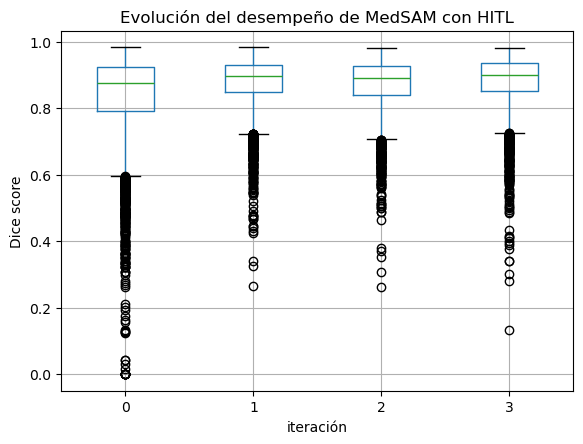

dice_score                                                    \
               count      mean       std       min        5%       25%   
iteration                                                                
0             5249.0  0.837269  0.129026  0.000000  0.576755  0.792793   
1             5249.0  0.878689  0.074714  0.264151  0.736370  0.847631   
2             5249.0  0.873295  0.075904  0.263158  0.727273  0.838462   
3             5249.0  0.881939  0.077399  0.133333  0.738531  0.850877   

                                                   
                50%       75%       95%       max  
iteration                                          
0          0.876712  0.924092  0.957016  0.983519  
1          0.897059  0.930913  0.960873  0.982369  
2          0.891228  0.927757  0.958521  0.980637  
3          0.900474  0.935247  0.963593  0.981668

In [9]:
# Boxplot of Dice score for each iteration (all lesions)
performance_df.boxplot(column='dice_score', by='iteration')
plt.suptitle('')
plt.title('Evolución del desempeño de MedSAM con HITL')
plt.xlabel('iteración')
plt.ylabel('Dice score')
if savefig:
    plt.savefig(Path.cwd() / 'resources' / 'results' /'dice_boxplots_comparison.png', bbox_inches='tight')
plt.show()
display(performance_df[['dice_score', 'iteration']].groupby('iteration').describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

In [10]:
iterations = performance_df['iteration'].unique()
iterations_count = len(iterations)
lesion_types_count = len(performance_df['label_description'].unique())
print(f"# iteraciones: {iterations_count}")
print(f"# tipos de lesión: {lesion_types_count}")

# iteraciones: 4
# tipos de lesión: 9


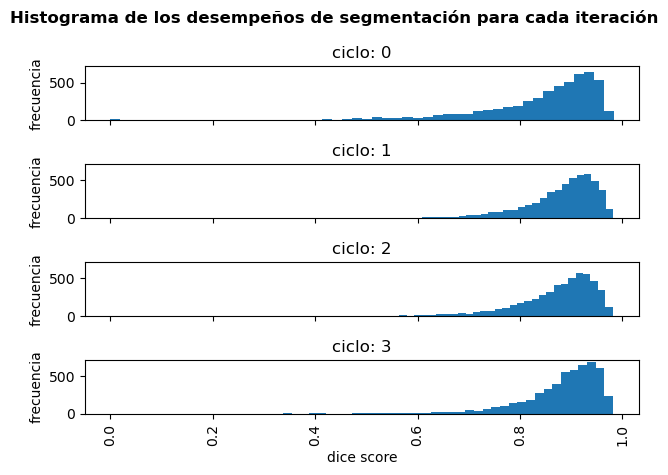

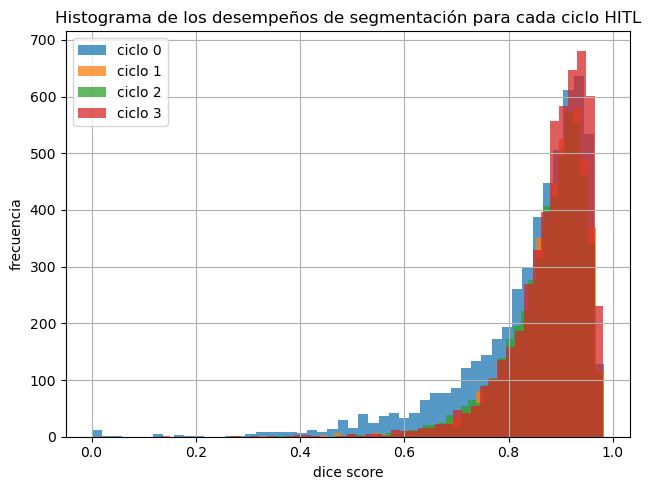

In [11]:
# Histogram of Dice score for each iteration (all lesions)
fig, ax = plt.subplots(nrows=iterations_count, ncols=1, sharex=True, sharey=True)
performance_df.hist(
    column='dice_score',
    by='iteration',
    bins=50,
    ax=ax
)
fig.suptitle('Histograma de los desempeños de segmentación para cada iteración', fontweight='bold')
for idx in range(iterations_count):
    ax[idx].set_ylabel('frecuencia')
    ax[idx].set_title(f"ciclo: {iterations[idx]}")
ax[-1].set_xlabel('dice score')
plt.tight_layout()
plt.show()
# Overlapped histograms
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5,5))
cmap = plt.get_cmap('tab10')
for it in iterations:
    performance_df[performance_df['iteration'] == it].hist(
        column='dice_score',
        bins=50,
        ax=ax,
        color=cmap(it),
        alpha=0.75,
        label=f"ciclo {it}"
    )
ax.legend()
ax.set_title('Histograma de los desempeños de segmentación para cada ciclo HITL')
ax.set_xlabel('dice score')
ax.set_ylabel('frecuencia')
plt.tight_layout()
if savefig:
    plt.savefig(Path.cwd() / 'resources' / 'results' / 'overlapped_histograms.png', bbox_inches='tight')
plt.show()

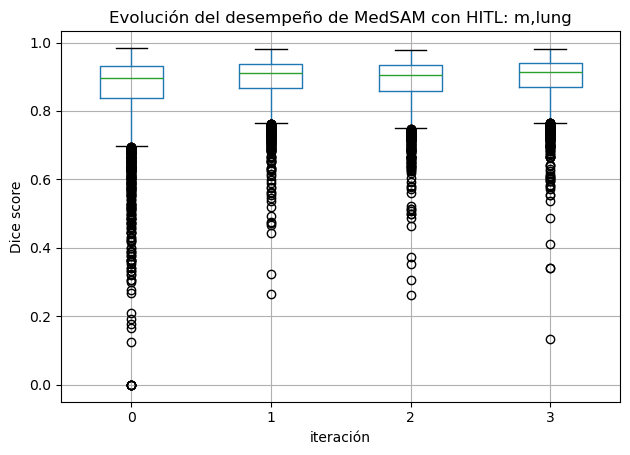

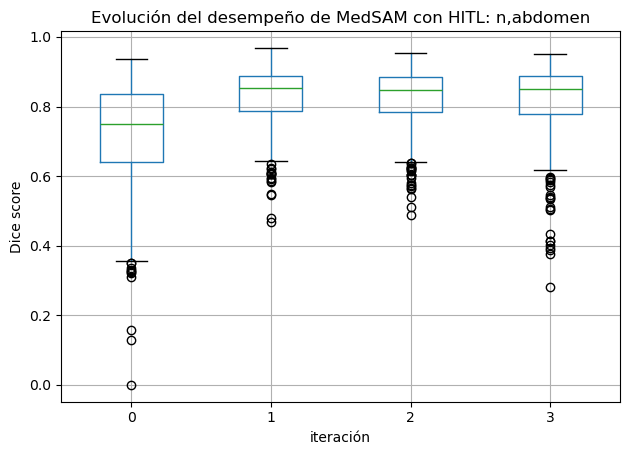

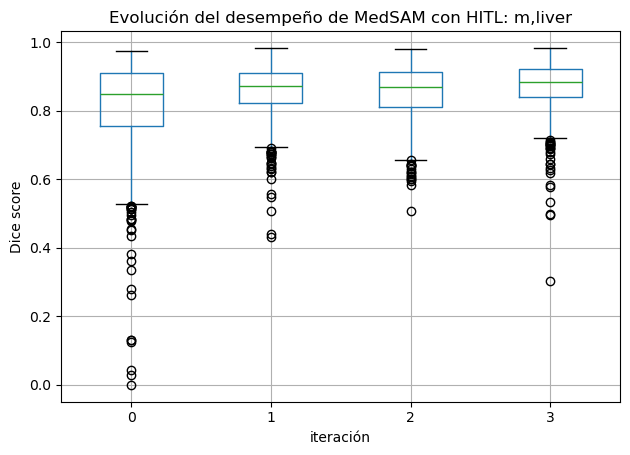

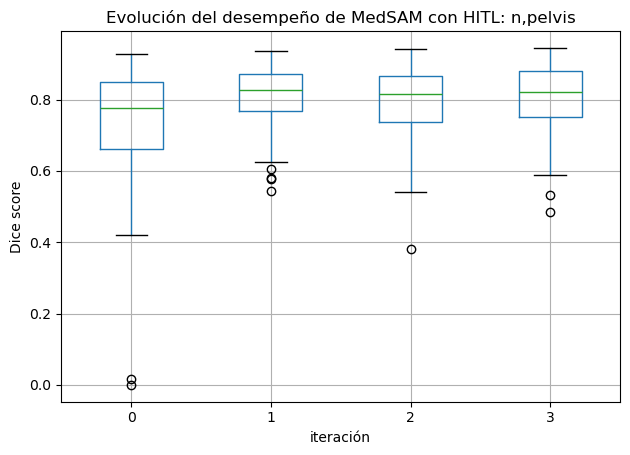

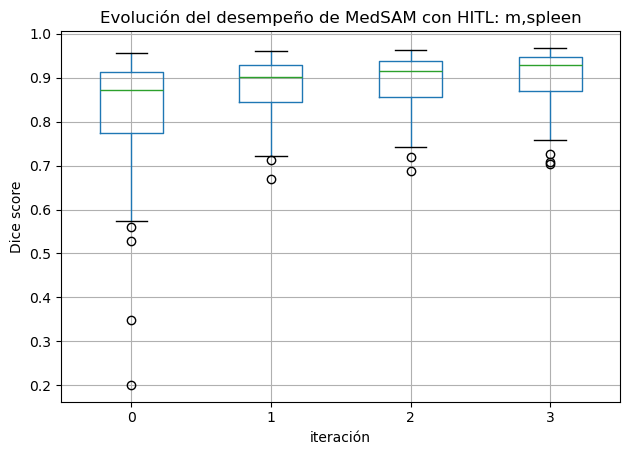

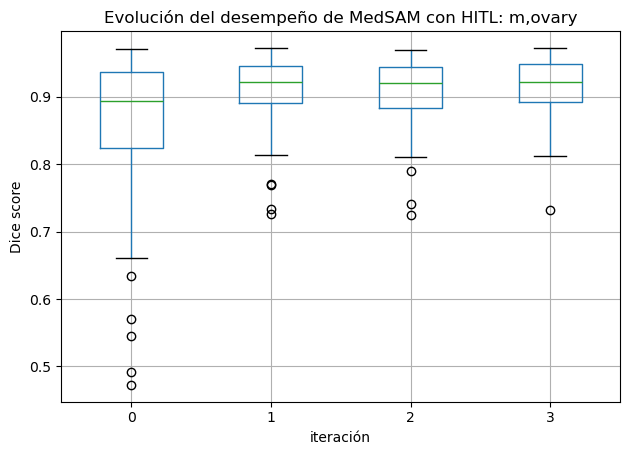

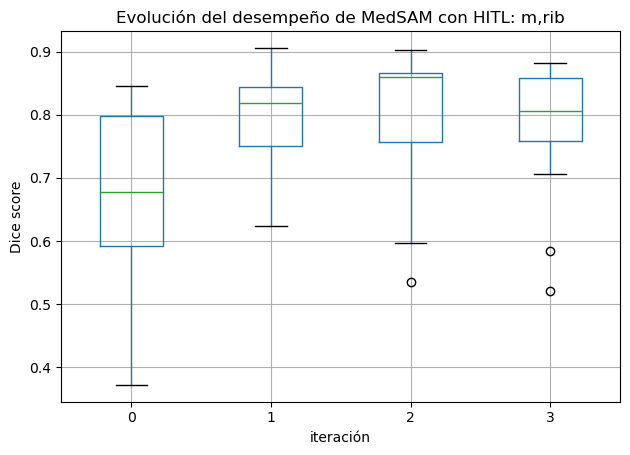

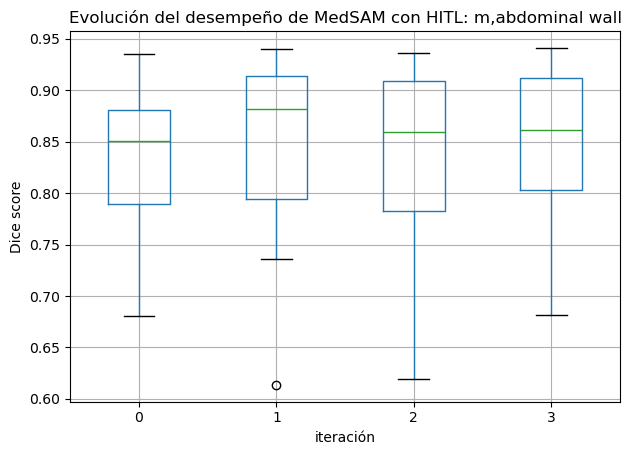

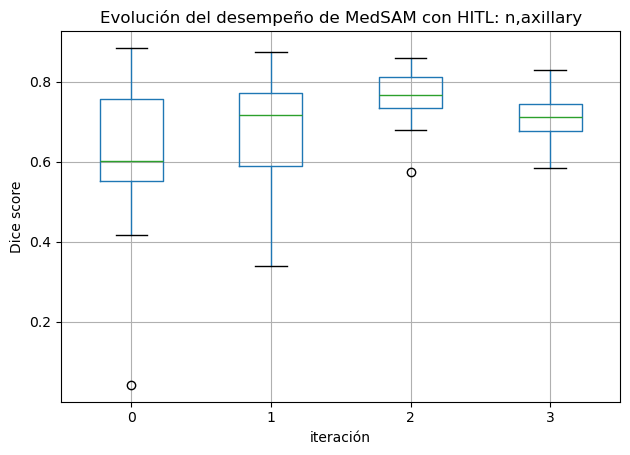

In [12]:
# Boxplot of Dice score for each iteration, dissagregated by lesion type
unique_lesions = list(performance_df['label_description'].unique())
for lesion in unique_lesions:
    performance_df[performance_df['label_description'] == lesion].boxplot(column='dice_score', by='iteration')
    plt.suptitle('')
    plt.title(f'Evolución del desempeño de MedSAM con HITL: {lesion}')
    plt.xlabel('iteración')
    plt.ylabel('Dice score')
    plt.tight_layout()
    plt.show()

In [13]:
display(performance_df.groupby(['label_description', 'iteration'])['dice_score'].describe())

count      mean       std       min       25%  \
label_description iteration                                                   
m,abdominal wall  0            20.0  0.837178  0.069270  0.680556  0.788967   
                  1            20.0  0.850531  0.085483  0.613636  0.794356   
                  2            20.0  0.832321  0.092303  0.619565  0.782415   
                  3            20.0  0.851629  0.075516  0.681481  0.802543   
m,liver           0           891.0  0.816270  0.130689  0.000000  0.754692   
                  1           891.0  0.860385  0.075025  0.430769  0.822988   
                  2           891.0  0.856919  0.077514  0.506667  0.810001   
                  3           891.0  0.872792  0.071365  0.303030  0.840000   
m,lung            0          3530.0  0.864660  0.109929  0.000000  0.837607   
                  1          3530.0  0.893854  0.064971  0.264151  0.867775   
                  2          3530.0  0.887359  0.067366  0.263158  0.859690   
                  3          3530.0  0.896664  0.065506  0.133333  0.870803   
m,ovary           0            82.0  0.854532  0.111971  0.472681  0.824460   
                  1            82.0  0.909640  0.052021  0.726434  0.890764   
                  2            82.0  0.907801  0.050149  0.724684  0.883837   
                  3            82.0  0.914773  0.043769  0.731780  0.892321   
m,rib             0            12.0  0.675509  0.141777  0.372240  0.591673   
                  1            12.0  0.797267  0.076222  0.623963  0.749927   
                  2            12.0  0.796342  0.119486  0.535180  0.756589   
                  3            12.0  0.773815  0.115168  0.520907  0.757934   
m,spleen          0            58.0  0.816580  0.148843  0.201117  0.773163   
                  1            58.0  0.876047  0.073537  0.669811  0.845220   
                  2            58.0  0.891681  0.063729  0.686981  0.855512   
                  3            58.0  0.899043  0.067726  0.704626  0.869834   
n,abdomen         0           515.0  0.720751  0.145427  0.000000  0.641914   
                  1           515.0  0.828222  0.082005  0.468111  0.788470   
                  2           515.0  0.823293  0.082228  0.487562  0.785409   
                  3           515.0  0.818270  0.102784  0.280268  0.779157   
n,axillary        0            18.0  0.609317  0.190293  0.042553  0.552781   
                  1            18.0  0.666051  0.152794  0.339623  0.589481   
                  2            18.0  0.761191  0.072962  0.573529  0.733111   
                  3            18.0  0.705653  0.070828  0.583333  0.676895   
n,pelvis          0           123.0  0.738543  0.154537  0.000000  0.662772   
                  1           123.0  0.811632  0.083063  0.544118  0.769583   
                  2           123.0  0.796566  0.097350  0.380952  0.736441   
                  3           123.0  0.803497  0.093580  0.486188  0.750328   

                                  50%       75%       max  
label_description iteration                                
m,abdominal wall  0          0.850516  0.881024  0.934911  
                  1          0.881587  0.913454  0.939873  
                  2          0.858888  0.909293  0.936248  
                  3          0.860907  0.911612  0.940810  
m,liver           0          0.848101  0.909480  0.975098  
                  1          0.871161  0.911033  0.982369  
                  2          0.870331  0.912787  0.980637  
                  3          0.884913  0.922881  0.981668  
m,lung            0          0.896246  0.931895  0.983519  
                  1          0.910692  0.937269  0.982051  
                  2          0.905263  0.933333  0.978947  
                  3          0.913471  0.941176  0.979914  
m,ovary           0          0.894224  0.937222  0.970973  
                  1          0.922395  0.945285  0.972091  
                  2          0.920503  0.944135  0.968731  
       

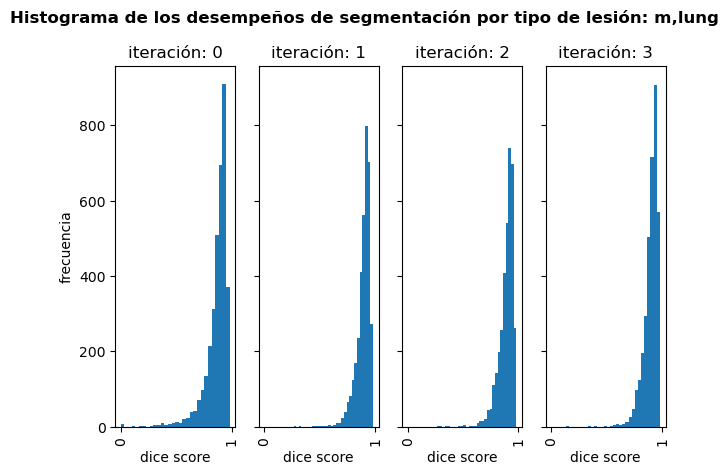

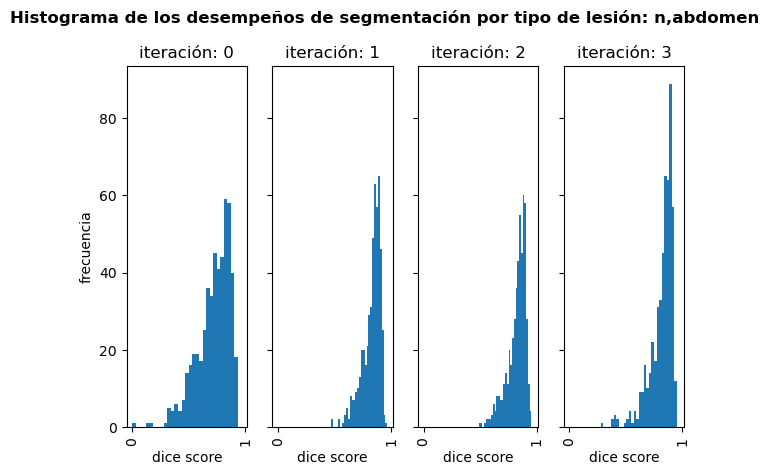

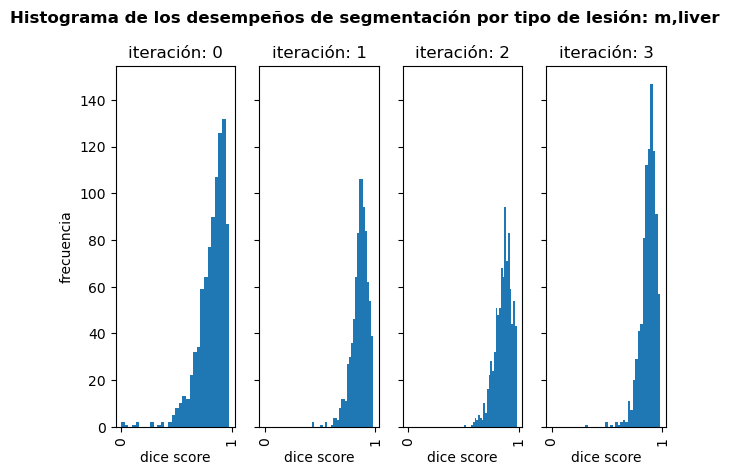

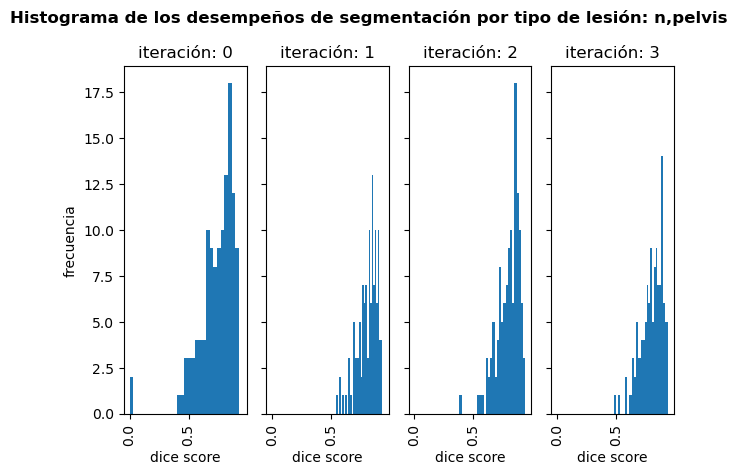

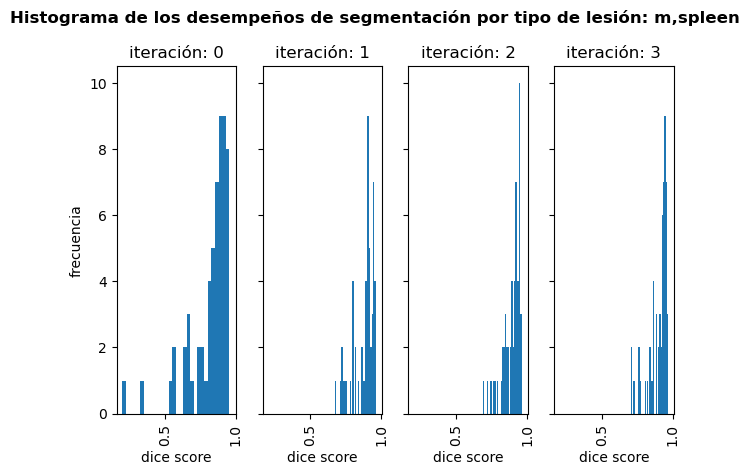

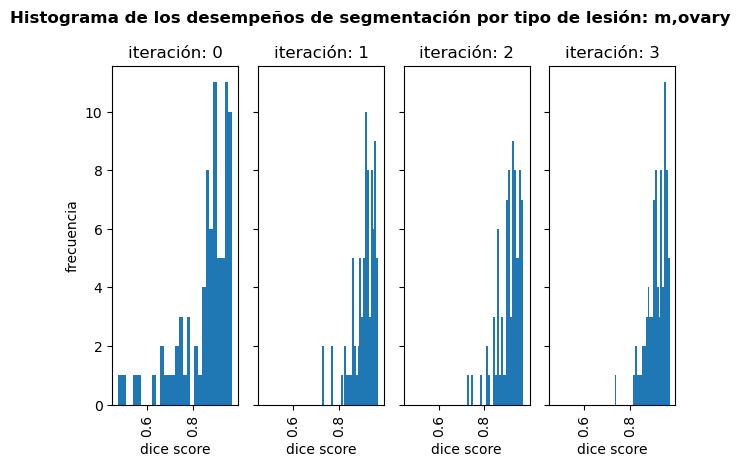

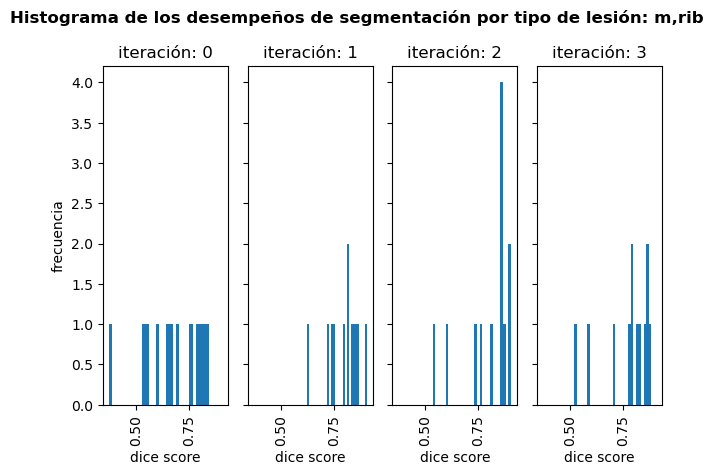

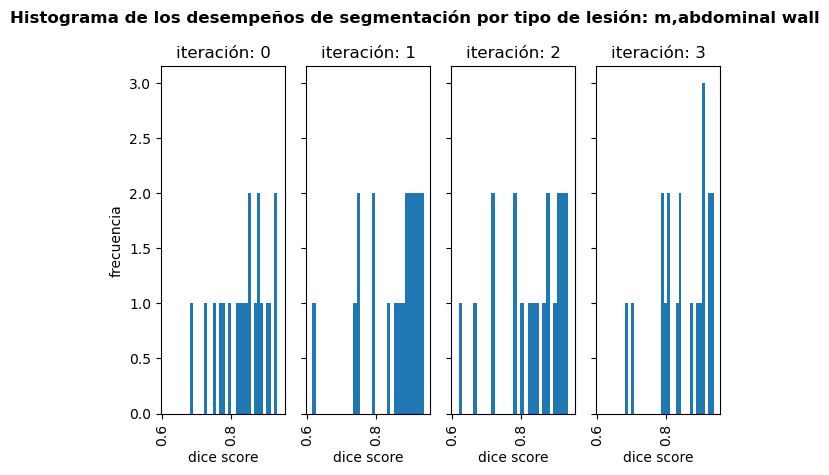

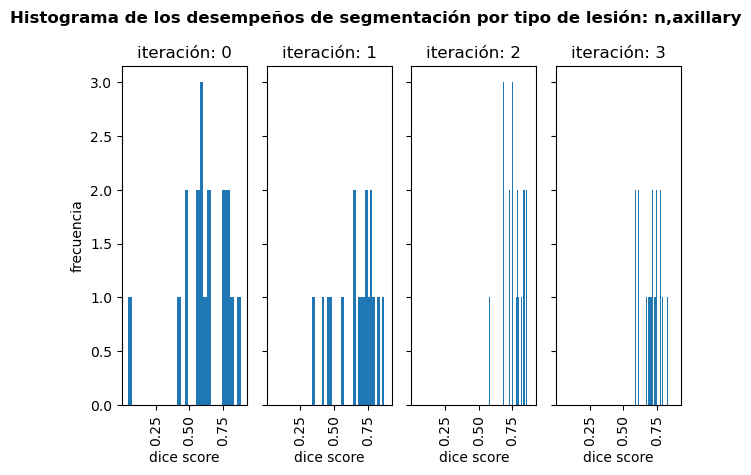

In [14]:
# Histogram of Dice score for each iteration, dissagregated by lesion type
for lesion in unique_lesions:
    fig, ax = plt.subplots(nrows=1, ncols=iterations_count, sharex=True, sharey=True)
    fig.suptitle(
        f'Histograma de los desempeños de segmentación por tipo de lesión: {lesion}',
        fontweight='bold'
    )
    performance_df[performance_df['label_description'] == lesion].hist(
        column='dice_score',
        by='iteration',
        bins=30,
        ax=ax
    )
    ax[0].set_ylabel('frecuencia')
    for idx in range(iterations_count):
        ax[idx].set_xlabel('dice score')
        ax[idx].set_title(f"iteración: {iterations[idx]}")
    plt.tight_layout()
    plt.show()

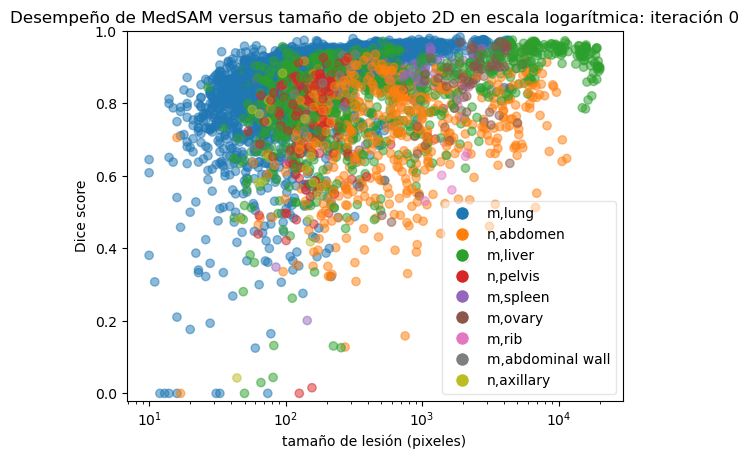

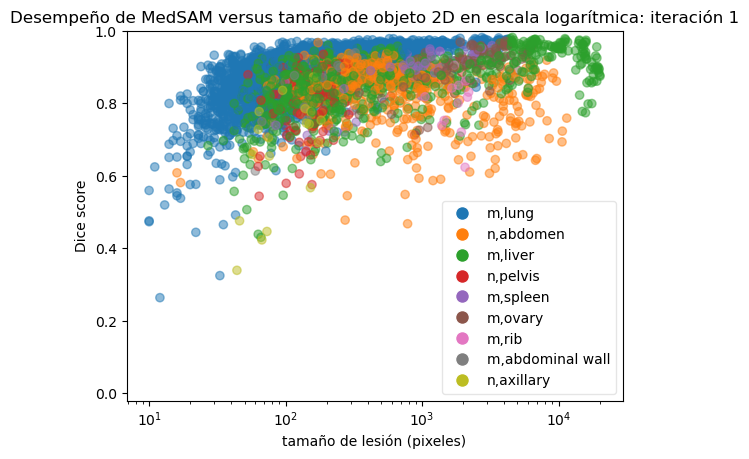

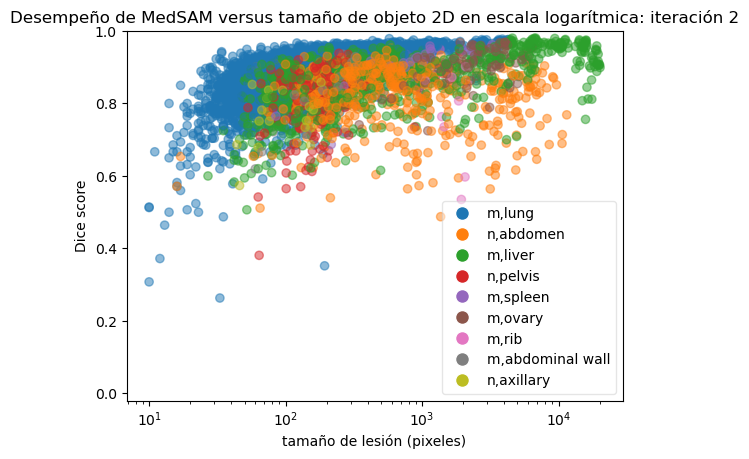

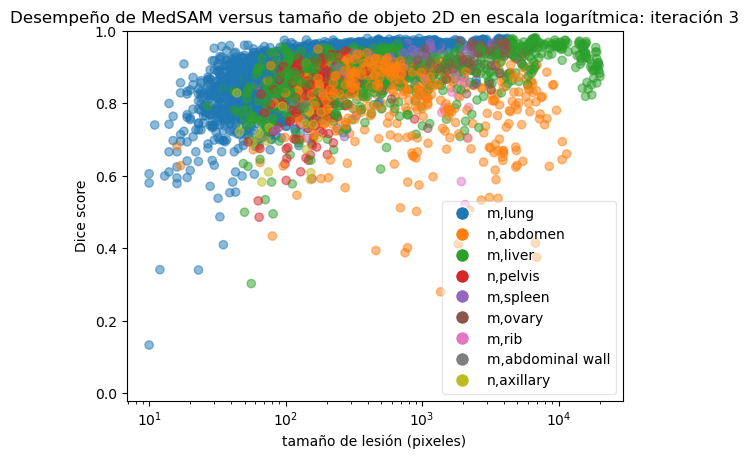

In [15]:
# Scatterplot of Dice versus object size, one plot for each iteration
iterations = list(performance_df['iteration'].unique())
# Add a color for each unique label description
cmap = plt.get_cmap('tab10')
color_mapping = {
    label: cmap(idx)
    for idx, label in enumerate(unique_lesions)
}
for iteration in iterations:
    _, ax = plt.subplots()
    filtered_df = performance_df[performance_df['iteration'] == iteration]
    colors = filtered_df["label_description"].map(color_mapping)
    ax.scatter(
        filtered_df['annotated_pixels'],
        filtered_df['dice_score'],
        c=colors.to_list(),
        label=filtered_df["label_description"],
        alpha=0.5
    )
    ax.set_xscale('log')
    ax.set_title(f'Desempeño de MedSAM versus tamaño de objeto 2D en escala logarítmica: iteración {iteration}')
    ax.set_xlabel('tamaño de lesión (pixeles)')
    ax.set_ylabel('Dice score')
    # Create legend labels based on unique values in 'label_description' column
    legend_labels = [
        Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color_mapping[value], label=value)
        for value in unique_lesions
    ]
    ax.legend(handles=legend_labels, framealpha=0.5)
    ax.set_ylim([-0.02, 1])
    if savefig:
        plt.savefig(
            Path.cwd() / "resources" / 'results' / f"scatterplot_performance_vs_object_size_hitl_iteration_{iteration}.png",
            transparent=True,
            bbox_inches='tight'
        )
    plt.show()

In [16]:
# Hypothesis testing for all dice scores
iteration_a_idx = 2
iteration_b_idx = 3
ttest_result, new_df = run_paired_t_test(
    performance_df,
    iteration_a_idx,
    iteration_b_idx
)
difference = new_df[f'dice_score_iteration_{iteration_b_idx}'] - new_df[f'dice_score_iteration_{iteration_a_idx}']
difference_sample_mean = np.mean(difference)
difference_sample_std = np.std(difference)
print(f"p value: {ttest_result.pvalue}")
print(f"difference sample mean: {difference_sample_mean}")
print(f"confidence interval: [{ttest_result.confidence_interval().low}, {ttest_result.confidence_interval().high}]")

p value: 2.744817650352877e-51
difference sample mean: 0.008643604953767356
confidence interval: [0.007531013161019923, 0.00975619674651479]


In [17]:
# Hypothesis testing for scores grouped by lesion type
for lesion in unique_lesions:
    filtered_df = performance_df[performance_df['label_description'] == lesion]
    ttest_result, new_df = run_paired_t_test(
        filtered_df,
        iteration_a_idx,
        iteration_b_idx
    )
    difference = new_df[f'dice_score_iteration_{iteration_b_idx}'] - new_df[f'dice_score_iteration_{iteration_a_idx}']
    difference_sample_mean = np.mean(difference)
    difference_sample_std = np.std(difference)
    print(f"lesion: {lesion}")
    print(f"p value: {ttest_result.pvalue}")
    print(f"difference sample mean: {difference_sample_mean}")
    print(f"confidence interval: [{ttest_result.confidence_interval().low}, {ttest_result.confidence_interval().high}]")
    print("-"*70)

lesion: m,lung
p value: 1.0133235875625504e-54
difference sample mean: 0.00930524163884488
confidence interval: [0.008154315665194568, 0.010456167612495192]
----------------------------------------------------------------------
lesion: n,abdomen
p value: 0.05042949128201314
difference sample mean: -0.005023273463637844
confidence interval: [-0.01005598298823225, 9.436060956560799e-06]
----------------------------------------------------------------------
lesion: m,liver
p value: 2.7286825612166356e-21
difference sample mean: 0.01587241589563527
confidence interval: [0.012667286100772782, 0.01907754569049776]
----------------------------------------------------------------------
lesion: n,pelvis
p value: 0.046351174770319664
difference sample mean: 0.006931080175342435
confidence interval: [0.00011388298270360343, 0.013748277367981267]
----------------------------------------------------------------------
lesion: m,spleen
p value: 0.014964051993917241
difference sample mean: 0.007362309

**Warning**: Existe una pequeña cantidad de ROIs (bounding boxes de objetos 2D) que están presentes en una iteración del HITL, pero no en las otras. Esta cantidad es del orden 1-5 ROIs.

**TODO**: Revisar dichos bounding boxes para cada iteración. Recordar que provienen del conjunto de test y de la ejecución del script `evaluate_CT_dataset.py` en [este repositorio](https://github.com/robertorojasp06/MedSAM).

In [18]:
# Get the dataframe with the performance difference between iterations
iterations = [2, 3]
pivot_df = performance_df[performance_df['iteration'].isin(iterations)].pivot(
    index=['bbox_original_fname', 'label_description', 'annotated_pixels'],
    columns='iteration',
    values='dice_score'
)
first_it_name = f"dice_iteration_{iterations[0]}"
second_it_name = f"dice_iteration_{iterations[1]}"
pivot_df.rename(
    columns={
        iterations[0]: first_it_name,
        iterations[1]: second_it_name
    },
    inplace=True
)
pivot_df['dice_difference'] = pivot_df[second_it_name] - pivot_df[first_it_name]
pivot_df.reset_index(inplace=True)
if savecsv:
    pivot_df.to_csv(Path.cwd() / 'resources' / 'results' / f'performance_difference_it{iterations[1]}_vs_it{iterations[0]}.csv', index=False)

# Evaluación de modelos CV en conjunto de test
- En esta sección se evalúa y compara los mejores modelos obtenidos en cada iteración de la Validación Cruzada, en relación a su desempeño de segmentación **sobre el conjunto de test**.

In [19]:
path_to_results = Path.cwd() / "resources" / 'final' / "HITL-iteration-3" / "test-evaluation"
path_to_best_cv_models = [
    {
        "cv_iteration": iteration,
        "path_to_performance": path
    }
    for iteration, path in enumerate(sorted(list(Path(path_to_results).glob("performance_cv*.json")), key= lambda x: x.parts[-1].split('_')[-1]))
]

In [20]:
def concatenate_cv_iteration_dfs(path_to_best_cv_models, keep_only_common_between_iterations=True):
    dfs = []
    for item in path_to_best_cv_models:
        with open(item['path_to_performance'], 'r') as file:
            df = pd.DataFrame(json.load(file)['bboxes'])
        df['cv_iteration'] = item['cv_iteration']
        dfs.append(df)
    concatenated_df = pd.concat(dfs, ignore_index=True).sort_values(by='cv_iteration')
    if keep_only_common_between_iterations:
        common_bboxes = set(concatenated_df['bbox_original_fname'])
        for iteration in concatenated_df['cv_iteration'].unique():
            common_bboxes = common_bboxes.intersection(set(concatenated_df[concatenated_df['cv_iteration'] == iteration]['bbox_original_fname']))
        concatenated_df = concatenated_df[concatenated_df['bbox_original_fname'].isin(common_bboxes)]
    return concatenated_df

In [21]:
# Concatenate performance from different CV iterations
best_models_performance_df = concatenate_cv_iteration_dfs(path_to_best_cv_models)
best_models_performance_df = add_patient_info_to_df(
    best_models_performance_df,
    path_to_patients,
    path_to_series
)
# Remove 2D objects with size smaller than "min_pixels_size"
best_models_performance_df = best_models_performance_df[best_models_performance_df["annotated_pixels"] >= min_size_pixels]

In [22]:
# Performance for each CV model grouped by patient
grouped = best_models_performance_df.groupby(['patient_id', 'diagnosis','cv_iteration'])['dice_score'].agg(['mean', 'std']).reset_index()
display(grouped)
if savecsv:
    grouped.to_csv(Path.cwd() / "resources" / "results" / "performance_on_test_grouped_by_patient.csv")

,patient_id,diagnosis,cv_iteration,mean,std
0,3,gallbladder cancer,0,0.817271,0.092455
1,3,gallbladder cancer,1,0.804555,0.098506
2,3,gallbladder cancer,2,0.814924,0.090423
3,3,gallbladder cancer,3,0.790727,0.096999
4,3,gallbladder cancer,4,0.799625,0.102304
5,3,gallbladder cancer,5,0.805081,0.101135
6,3,gallbladder cancer,6,0.805372,0.094420
7,3,gallbladder cancer,7,0.802569,0.103899
8,3,gallbladder cancer,8,0.806177,0.092157
9,3,gallbladder cancer,9,0.813686,0.087661


In [23]:
# Mean performance for each CV model
grouped = best_models_performance_df.groupby(['cv_iteration'])['dice_score'].agg(['mean', 'std']).reset_index()
display(grouped)

,cv_iteration,mean,std
0,0,0.876972,0.078092
1,1,0.868635,0.081331
2,2,0.873743,0.086296
3,3,0.859277,0.093386
4,4,0.872114,0.079869
5,5,0.863842,0.091573
6,6,0.878564,0.077742
7,7,0.877911,0.078402
8,8,0.868244,0.085863
9,9,0.870177,0.080902


In [24]:
# List of lesions for each patient in the set
grouped = best_models_performance_df[best_models_performance_df["cv_iteration"] == 10].groupby(['patient_id', 'diagnosis'])['foreground_label'].unique().reset_index(name="lesions")
display(grouped)

,patient_id,diagnosis,lesions
0,3,gallbladder cancer,"[1, 2, 3, 4]"
1,10,melanoma,"[2, 1, 3]"
2,13,gastric cancer,"[2, 1]"
3,15,bladder cancer,"[1, 2, 3]"
4,18,colon cancer,"[4, 7, 6, 3, 5, 2, 1]"
5,28,colon cancer,"[84, 93, 92, 91, 87, 86, 83, 80, 73, 58, 98, 9..."
6,30,rectal cancer,"[3, 2, 4, 5, 1, 10, 8, 9, 12, 11, 6, 7, 13, 14]"
7,35,gastric cancer,"[2, 1, 4, 7]"


In [25]:
# Number of 2d objects evaluated for each patient in the set
grouped = best_models_performance_df[best_models_performance_df["cv_iteration"] == 10].groupby(['patient_id', 'diagnosis']).size().reset_index(name="objects_count")
display(grouped)

,patient_id,diagnosis,objects_count
0,3,gallbladder cancer,344
1,10,melanoma,18
2,13,gastric cancer,174
3,15,bladder cancer,115
4,18,colon cancer,116
5,28,colon cancer,3900
6,30,rectal cancer,474
7,35,gastric cancer,102


In [26]:
# Performance of default MedSAM grouped by patient
grouped = performance_df[performance_df['iteration'] == 0].groupby(['patient_id', 'diagnosis'])['dice_score'].agg(['mean', 'std']).reset_index()
display(grouped)

,patient_id,diagnosis,mean,std
0,3,gallbladder cancer,0.710860,0.153463
1,10,melanoma,0.609317,0.190293
2,13,gastric cancer,0.860871,0.100715
3,15,bladder cancer,0.734733,0.157762
4,18,colon cancer,0.753553,0.110475
5,28,colon cancer,0.854380,0.118376
6,30,rectal cancer,0.830361,0.122630
7,35,gastric cancer,0.851130,0.104907


# Distribución de los datos por conjunto y diagnóstico

In [27]:
path_to_cv_splits = Path.cwd() / "resources" / 'final' / "HITL-iteration-3" / "model-selection" / "splits.csv"
splits_df = pd.read_csv(path_to_cv_splits).drop_duplicates(
    subset=['filename'],
    ignore_index=True
)
unique_test_bboxes_df = performance_df.drop_duplicates(
    subset=['bbox_original_fname'],
    ignore_index=True
)
patients_df = pd.read_csv(path_to_patients)
splits_df = pd.merge(
    splits_df,
    patients_df[['patient_id', 'sex', 'age', 'diagnosis']],
    how='inner',
    left_on='patient_code',
    right_on='patient_id'
)
splits_df.drop(columns=['patient_code'], inplace=True)
selected_columns = ['patient_id', 'diagnosis']
train_patients = splits_df.drop_duplicates(subset=['patient_id'])[selected_columns]
train_patients['subset'] = 'train'
test_patients = unique_test_bboxes_df.drop_duplicates(subset=['patient_id'])[selected_columns]
test_patients['subset'] = 'test'
patients_concatenated_df = pd.concat([train_patients, test_patients], ignore_index=True)
display(patients_concatenated_df)

,patient_id,diagnosis,subset
0,2,gastric cancer,train
1,12,breast cancer,train
2,23,colon cancer,train
3,8,gastric cancer,train
4,16,lung cancer,train
5,31,lung cancer,train
6,44,ovarian cancer,train
7,24,gastric cancer,train
8,1,lung cancer,train
9,22,colon cancer,train


In [28]:
def plot_pie_chart(df, color_map=None, title='dataset_distribution.png', savefig=False):
    # Group the dataframe by the 'subset' column
    grouped = df.groupby('subset')

    if not color_map:
        # Create a dictionary to store the mapping of 'diagnosis' values to colors
        color_map = {}

        # Iterate over the groups to create consistent color mapping
        for subset, data in grouped:
            # Get unique 'diagnosis' values for the subset
            unique_diagnosis = data['diagnosis'].unique()

            # Check if colors are already assigned for 'diagnosis' values
            for diagnosis in unique_diagnosis:
                if diagnosis not in color_map:
                    # Assign a color to the 'diagnosis' value if not already assigned
                    color_map[diagnosis] = plt.cm.tab20(len(color_map))

    _, axes = plt.subplots(nrows=1, ncols=len(df['subset'].unique()), figsize=(10,4))
    # Plot a pie chart for each subset
    for subset, data in grouped:
        idx = 0 if subset == 'train' else 1
        # Get value counts of 'diagnosis' for the subset
        value_counts = data['diagnosis'].value_counts()

        # Create a list of colors for 'diagnosis' values based on the color map
        colors = [color_map[diagnosis] for diagnosis in value_counts.index]

        # Plot pie chart
        axes[idx].pie(
            value_counts,
            labels=value_counts.index,
            colors=colors,
            autopct=lambda x: f'{x/100 * sum(value_counts.to_list()):.0f}',
            startangle=90
        )

        # Add title
        axes[idx].set_title(f"{'Entrenamiento' if subset == 'train' else 'Test'}", fontweight='bold')

    # Save fig
    plt.tight_layout()
    if savefig:
        plt.savefig(Path.cwd() / "resources" / 'results' / title)
    # Show plot
    plt.show()

In [29]:
# Get unique colors
color_map = {}
unique_diagnosis = patients_concatenated_df['diagnosis'].unique()

# Check if colors are already assigned for 'diagnosis' values
for diagnosis in unique_diagnosis:
    if diagnosis not in color_map:
        # Assign a color to the 'diagnosis' value if not already assigned
        color_map[diagnosis] = plt.cm.tab20(len(color_map))

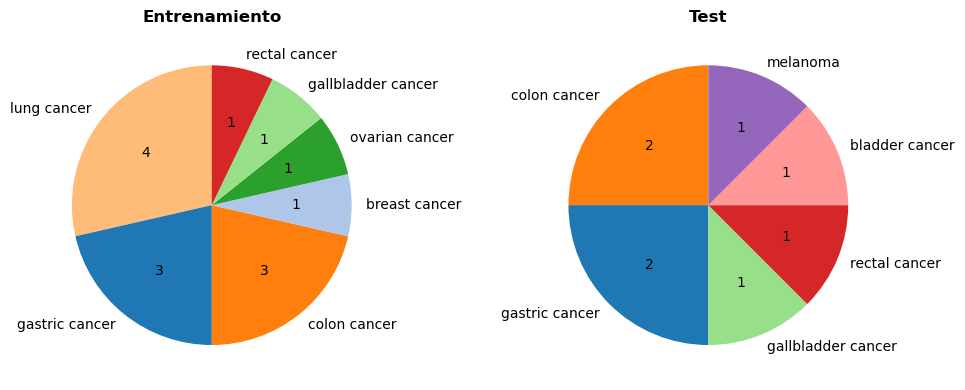

In [30]:
# Patients distribution
plot_pie_chart(patients_concatenated_df, color_map=color_map, title='patients_distribution.png', savefig=savefig)

,series_uuid,patient_id,diagnosis,subset
0,1.3.12.2.1107.5.1.4.83504.30000022071212080050...,2,gastric cancer,train
1,1.3.12.2.1107.5.1.4.83504.30000019041511214045...,12,breast cancer,train
2,1.3.12.2.1107.5.1.4.83504.30000019070312170000...,12,breast cancer,train
3,1.3.12.2.1107.5.1.4.83504.30000019103012204275...,12,breast cancer,train
4,1.3.12.2.1107.5.1.4.83504.30000021072912214330...,23,colon cancer,train
5,1.3.12.2.1107.5.1.4.83504.30000021110312383749...,23,colon cancer,train
6,1.3.12.2.1107.5.1.4.83504.30000021120712090076...,23,colon cancer,train
7,1.3.12.2.1107.5.1.4.83504.30000022112912564272...,8,gastric cancer,train
8,1.3.12.2.1107.5.1.4.83504.30000023080813283914...,16,lung cancer,train
9,1.3.12.2.1107.5.1.4.83504.30000023091403342212...,16,lung cancer,train


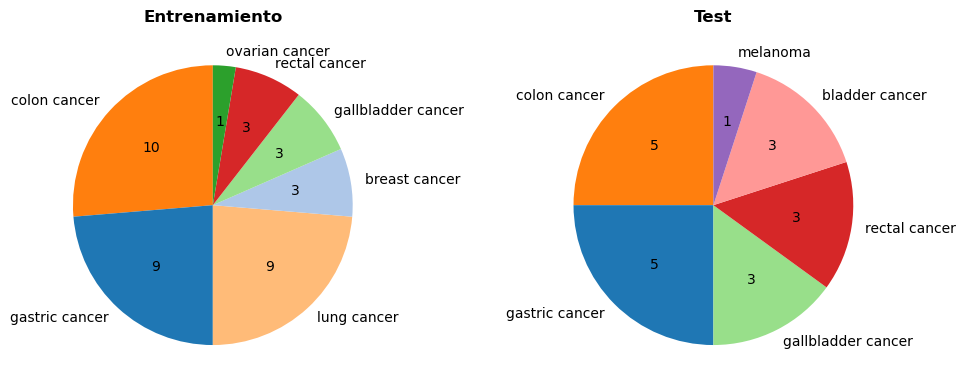

In [31]:
# CTs distribution
selected_columns = ['series_uuid', 'patient_id', 'diagnosis']
train_cts_df = splits_df.drop_duplicates(subset=['series_uuid'], ignore_index=True)[selected_columns]
train_cts_df['subset'] = 'train'
test_cts_df = unique_test_bboxes_df.drop_duplicates(subset=['study'], ignore_index=True)[selected_columns]
test_cts_df['subset'] = 'test'
cts_concatenated_df = pd.concat([train_cts_df, test_cts_df], ignore_index=True)
display(cts_concatenated_df)
plot_pie_chart(cts_concatenated_df, color_map=color_map, title='cts_distribution.png', savefig=savefig)